<a href="https://colab.research.google.com/github/Mingnarto/TensorFlow/blob/main/NLP_in_TensorFlow_Kaggle's_introduction_to_NLP_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a6b2a096-7e22-ff8d-b9bd-812746a7e56b)


## Get a helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-07-15 06:54:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-15 06:54:57 (92.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import io
import tensorflow_hub as hub
import time
import matplotlib.pyplot as plt

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (txt samples of Tweets labelled as disaster or not disaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2021-07-15 06:55:00--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-07-15 06:55:00 (103 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training samples
random_index = random.randint(0, len(train_df)-5)  # Create random indexes not higher than the total number of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target:', '(real disaster)' if target > 0 else '(not real disaster)')
  print(f'Text:\n{text}\n')
  print('---\n')

Target: (real disaster)
Text:
Heavy rain frequent thunder and gusty winds moving into parts of Uptown and Midtown. http://t.co/KQJevYqzLV - CN http://t.co/HmWhob7prs

---

Target: (real disaster)
Text:
@modnao23 the hail is ruining everything. Plus my car I haven't even gotten yet. Have yet another killer migraine and I lost my glasses. ??

---

Target: (real disaster)
Text:
BBC Forced To Retract False Claims About Cyclone Pam http://t.co/ciHC8Nrc9h via @wordpressdotcom

---

Target: (not real disaster)
Text:
Super sweet and beautiful :) https://t.co/TUi9uwBvVp

---

Target: (real disaster)
Text:
RT_America: RT RT_com: Eye of Super Typhoon Soudelor seen from space (TIME-LAPSE) https://t.co/FC3BxRtHPG http://t.co/BIU4koWGlz

---



### Split data into training and validation sets

In [ ]:
# use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,  # use 10% of training data for validation split
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
- Tokenization - direct mapping of token (a token could be a word or a charcater) to number
- Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
# Use the deafult TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None,  # how many words in the vocabulary (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,  # create groups of n-words?
                                    output_mode='int',  # how to map tokens numbers
                                    output_sequence_length=None,  # how long do you want your sequences to be
                                    pad_to_max_tokens=True)

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000  # max number of words to have in our vocabulary
max_length = 15  # max length our sequences will be (e.g. how many words from a Tweet does a model see), means if the number of words is 30 the model will only look until 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence})\n\nVentorized version:')
text_vectorizer([random_sentence])

Original text:
 #hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/6ioaBSl6I7 #prebreak #best)

Ventorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 175, 1544, 1359, 1501,    5,  481,    4,    3, 1358,    7,  389,
         422,    4,  458,    4]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  # get all of the unique words in our training data
top_5_words = words_in_vocab[:5]  # get the most common words
bottom_5_words = words_in_vocab[-5:]  # get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding layer

To mekae our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most aboout for our embedding layer:
- `input_dim` = the size of our vocabulary
- `output_dim` = the size of the output embedding vecor, for example, a value of 100 would mean each token gets represented by a vector 100 long
- `input_length` = length of the sequences being passed to the embedding layer

In [ ]:
embedding = layers.Embedding(input_dim=max_vocab_length,  # set input shape
                             output_dim=128,  # output shape
                             embeddings_initializer='uniform',
                             input_length=max_length)  # how long is each input

embedding                     

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
        \n\nEmbedded version:')

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 .@RaniaKhalek true. I faced everything from 'Is Bin Laden your uncle?' to 'Hopefully Afghanistan will be bombed'. Children can be very ugly.        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00907751, -0.03253768, -0.03205167, ...,  0.03204106,
         -0.02514553, -0.00850205],
        [ 0.02665557, -0.00293163,  0.02084608, ..., -0.00727965,
         -0.00497506, -0.02698405],
        [ 0.0132792 , -0.02959605,  0.01290934, ..., -0.04351696,
         -0.03318029, -0.01681866],
        ...,
        [-0.00692635, -0.04372942, -0.00313397, ...,  0.02406584,
          0.03707721,  0.04303179],
        [-0.02942356, -0.04989276,  0.000212  , ..., -0.04314805,
          0.02044905,  0.00123969],
        [-0.00961908,  0.02992492, -0.0437938 , ..., -0.0481127 ,
         -0.0051545 ,  0.00116838]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-9.07751173e-03, -3.25376764e-02, -3.20516713e-02, -3.36058512e-02,
        -4.40988541e-02,  3.17324437e-02,  1.36599652e-02, -3.63294035e-03,
        -1.51820891e-02, -4.65544239e-02, -1.72449835e-02, -4.77869622e-02,
        -2.15860251e-02, -2.46007089e-02,  2.72012837e-02,  2.05592178e-02,
        -4.34371717e-02,  8.57336447e-03,  3.59299295e-02, -4.18154486e-02,
        -3.15060616e-02,  1.10308528e-02,  3.49225663e-02, -4.08305041e-02,
        -1.14940032e-02,  2.98130848e-02, -2.52237562e-02, -7.53403828e-03,
        -1.00253448e-02, -3.78877521e-02,  2.43082754e-02,  3.46103944e-02,
        -3.74933332e-03, -2.06743237e-02,  4.10194732e-02,  3.06963921e-03,
        -3.66640799e-02,  1.04401931e-02, -1.17086880e-02,  3.79046686e-02,
        -6.28441572e-03,  2.36301161e-02, -7.38938898e-03,  2.73268856e-02,
         2.43773311e-03,  1.33432038e-02,  5.05480915e-03,  1.59884207e-02,
         4.28546704e-02,  2.73475312e-0

## Modeling a text dataset (running a series of experimentats)

Now we've got way to turn our text sequences into numbers, it's time to start building a series of modeling experiments.

We'll start with a baseline and move on from there.

- Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- Model 1: Feed-forward neural network (dense model_
- Model 2: LSTM model (RNN)
- Model 3: GRU model (RNN)
- Model 4: Bidirectional Neural Network (RNN)
- Model 5: 1D Convolutional Neural Network (CNN)
- Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learrning for NLP)
- Model 7: Same as model 6 with 100% of training data

How are we going to approach all of these?

Use the standard steps in modeling steps:
- Create a model
- Build a model
- Fit a model
- Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modeling experiments, it's important to create a baseline model so you've got a benchmark for futeure experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using TF-IDF formula to convert our words to numbers

> **NOTE:** It's common practice to use non-DL algorithms as a baseline because as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [ ]:
# Create tokenization and modeling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),  # convert words to numbers using tfidf
                    ('clf', MultinomialNB())  # model the text (clf == classifier)
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}&')

Our baseline model achieves an accuracy of: 79.27&


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and can be easily fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
- Accuracy
- Precision
- Recall
- F1-score

> For a deep overview of many different methods, see the Sklearn documentation: https://colab.research.google.com/drive/1UKkJe16LFi4ZfQRfbxze6236vn5bzafU#scrollTo=b5kQos0ed4Zg

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true, y_pred):
  '''
  calculates model accuracy, precision, recall and f1-score of a binary classification model.
  '''
  # Calsulate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using 'weighted' average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [ ]:
# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [ ]:
# Build model with the FUnctional API
inputs = layers.Input(shape=(1,), dtype=tf.string)  # input are 1-dimensional strings
x = text_vectorizer(inputs)  # turn the input text into numbers
x = embedding(x)  # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x)  # condense the feature vector for each token to one vector
#x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # create the output layer, want binary oututs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.summary()  # old summary (without GlobalAveragePooling1D)

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20210715-065509
Epoch 1/5
215/215 [==============================] - 9s 24ms/step - loss: 0.6138 - accuracy: 0.6971 - val_loss: 0.5387 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4430 - accuracy: 0.8194 - val_loss: 0.4704 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.3477 - accuracy: 0.8599 - val_loss: 0.4563 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2852 - accuracy: 0.8921 - val_loss: 0.4667 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2378 - accuracy: 0.9132 - val_loss: 0.4773 - val_accuracy: 0.7782


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4773 - accuracy: 0.7782


[0.4772835373878479, 0.778215229511261]

In [ ]:
# Check the results (old)
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4773 - accuracy: 0.7782


[0.4772835373878479, 0.778215229511261]

In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [ ]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.4061289], dtype=float32)

In [ ]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.4061289 ],
       [0.80760115],
       [0.9980299 ],
       [0.12432486],
       [0.10916305],
       [0.93406355],
       [0.93002963],
       [0.9940824 ],
       [0.9703766 ],
       [0.3057091 ]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.82152230971128,
 'f1': 0.7758810170952618,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129}

In [ ]:
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()
embed_weights

[array([[-0.04590741, -0.0299396 ,  0.03558392, ..., -0.0280385 ,
         -0.06216237,  0.04303638],
        [-0.01177409, -0.02437172, -0.04245682, ..., -0.00957391,
         -0.04097467,  0.03138991],
        [ 0.04032651, -0.0097938 , -0.01991646, ...,  0.04531282,
          0.00649192,  0.00683686],
        ...,
        [ 0.03307874,  0.02977545,  0.01374917, ..., -0.01520012,
          0.04286638,  0.04215838],
        [-0.08403958,  0.05443313,  0.08289906, ..., -0.05052716,
         -0.01649883,  0.04637718],
        [-0.05943283,  0.04435625,  0.04476077, ..., -0.03533433,
         -0.02061126,  0.06952292]], dtype=float32)]

In [ ]:
# Shape of embedding layer
embed_weights_shape = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights_shape.shape)  # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [ ]:
# Create embedding files (we've got this from TensorFlow's word wmbeddings documentation)
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights_shape[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from Colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   #files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent network is to use the representation of a previous input to aid the representation of a later input.

> **Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modeling lecture https://youtu.be/qjrad0V0uJE
- Chris Olah's intro to LSTM's: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/


### Model 2: LSTM

LSTM = Long Short Term Memory (one of the most popular LSTM sells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [ ]:
# Create an LSTM model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(units=64, return_sequences=True)(x)  # when you're stacking RNN celss together, you need to set return_sequences=True
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation='relu')(x)
#print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210715-065554
Epoch 1/5
215/215 [==============================] - 11s 26ms/step - loss: 0.2230 - accuracy: 0.9241 - val_loss: 0.5294 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1596 - accuracy: 0.9415 - val_loss: 0.6414 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1287 - accuracy: 0.9529 - val_loss: 0.6396 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1081 - accuracy: 0.9593 - val_loss: 0.7120 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0877 - accuracy: 0.9650 - val_loss: 0.8789 - val_accuracy: 0.7756


In [ ]:
# Make predictions with LSTM
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[1.0141405e-02],
       [8.8653791e-01],
       [9.9976426e-01],
       [3.6397189e-02],
       [9.6726144e-04],
       [9.9851829e-01],
       [9.0299141e-01],
       [9.9980551e-01],
       [9.9969530e-01],
       [3.9869609e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.55905511811024,
 'f1': 0.7733619560087615,
 'precision': 0.7777490986405654,
 'recall': 0.7755905511811023}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or Gated Recurrent UnicodeTranslateError

The Grue cell has similar features to an LSTM cell but has less parameters.

In [ ]:
# Build and RNN using GRU cell
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#print(x.shape)
#x = layers.GRU(64, return_sequences=True)(x)  # if you want to stack layers on top of each other, you need return_sequences = True
# print(x.shape)
# x = layers.LSTM(42, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(99)(x)
# print(x.shape)
#x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_3. compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210715-065637
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.1608 - accuracy: 0.9365 - val_loss: 0.7710 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0861 - accuracy: 0.9686 - val_loss: 0.7884 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0715 - accuracy: 0.9720 - val_loss: 0.8908 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0609 - accuracy: 0.9736 - val_loss: 1.1446 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0557 - accuracy: 0.9774 - val_loss: 1.0954 - val_accuracy: 0.7835


In [ ]:
# Make some predictions with our model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[5.3176829e-03],
       [8.3893108e-01],
       [9.9985433e-01],
       [1.1884013e-01],
       [1.1297951e-04],
       [9.9973720e-01],
       [8.0875164e-01],
       [9.9991655e-01],
       [9.9989569e-01],
       [8.3434665e-01]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 78.34645669291339,
 'f1': 0.7817956468843655,
 'precision': 0.7847784624516524,
 'recall': 0.7834645669291339}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [ ]:
# Build a bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_4.compile (loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210715-065722
Epoch 1/5
215/215 [==============================] - 9s 28ms/step - loss: 0.1038 - accuracy: 0.9721 - val_loss: 0.8819 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0535 - accuracy: 0.9768 - val_loss: 1.1456 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0472 - accuracy: 0.9783 - val_loss: 1.2567 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0422 - accuracy: 0.9804 - val_loss: 1.4572 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0561 - accuracy: 0.9761 - val_loss: 1.2641 - val_accuracy: 0.7743


In [ ]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.5054409e-03],
       [6.6763967e-01],
       [9.9965453e-01],
       [1.8117182e-01],
       [2.2515449e-05],
       [9.9916315e-01],
       [6.6384822e-01],
       [9.9996829e-01],
       [9.9987614e-01],
       [9.8111594e-01]], dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.42782152230971,
 'f1': 0.7729333240681188,
 'precision': 0.7747317935775544,
 'recall': 0.7742782152230971}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previous we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)

## Model 5: Conv1D

For different explanations of parameters see:
- https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
- Difference between 'same' and 'valid' padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(['this is a test sentence']))  # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,  # this is also referred to as ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1,  # default
                        activation='relu',
                        padding='valid')  # default = 'valid', the output is smaller than the input shape, 'same' means output is same shape as input
conv_1d_output = conv_1d(embedding_test)  # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)  # equivalent to 'get the most important feature' or 'get the feature with the highest value'

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02445515,  0.06482767,  0.02868516, ..., -0.04384512,
          0.01812091,  0.05473163],
        [ 0.06100331,  0.034117  ,  0.02910906, ..., -0.02260356,
         -0.00945901, -0.01367901],
        [-0.04728117,  0.02588437, -0.03082003, ..., -0.0263982 ,
         -0.05506435,  0.01228437],
        ...,
        [-0.04849482,  0.00067374,  0.00788176, ..., -0.03632676,
         -0.02401611,  0.0006143 ],
        [-0.04849482,  0.00067374,  0.00788176, ..., -0.03632676,
         -0.02401611,  0.0006143 ],
        [-0.04849482,  0.00067374,  0.00788176, ..., -0.03632676,
         -0.02401611,  0.0006143 ]]], dtype=float32)>

In [ ]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.01544614, 0.        , 0.05017765, 0.        , 0.        ,
         0.02571294, 0.        , 0.        , 0.        , 0.        ,
         0.02250774, 0.05348108, 0.05891936, 0.        , 0.04179778,
         0.00415229, 0.08622937, 0.        , 0.        , 0.        ,
         0.07672321, 0.        , 0.02493857, 0.0462534 , 0.01435422,
         0.02580136, 0.        , 0.        , 0.04331142, 0.0602425 ,
         0.        , 0.04642853],
        [0.        , 0.        , 0.02137715, 0.02148406, 0.        ,
         0.        , 0.        , 0.03171972, 0.        , 0.0622806 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.03619883, 0.02333844, 0.01851298, 0.02973832, 0.02769117,
         0.        , 0.09139614, 0.03199997, 0.        , 0.        ,
         0.        , 0.        , 0.03082143, 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.04653195, 0.0119

In [ ]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.01544614, 0.        , 0.05017765, 0.02148406, 0.01751968,
        0.02571294, 0.04280306, 0.03171972, 0.        , 0.0622806 ,
        0.06648014, 0.05348108, 0.05891936, 0.01997402, 0.04179778,
        0.03619883, 0.08622937, 0.02484159, 0.02973832, 0.11463992,
        0.07672321, 0.09385528, 0.03199997, 0.0462534 , 0.01435422,
        0.02580136, 0.08010072, 0.03082143, 0.04331142, 0.0602425 ,
        0.06205616, 0.04642853]], dtype=float32)>

In [ ]:
# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
#x = layers.Dense(64, activation='relu)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile the Conv1D
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_conv1D')])

Saving TensorBoard log files to: model_logs/model_5_conv1D/20210715-065814
Epoch 1/5
215/215 [==============================] - 7s 22ms/step - loss: 0.1215 - accuracy: 0.9591 - val_loss: 0.8892 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0734 - accuracy: 0.9721 - val_loss: 1.0149 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0616 - accuracy: 0.9768 - val_loss: 1.1107 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0541 - accuracy: 0.9783 - val_loss: 1.2136 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0522 - accuracy: 0.9778 - val_loss: 1.2119 - val_accuracy: 0.7585


In [ ]:
# Make some predictions with our Con1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[2.2288820e-01],
       [9.8714441e-01],
       [9.9960846e-01],
       [3.2328308e-02],
       [1.5247774e-07],
       [9.9850368e-01],
       [9.9151683e-01],
       [9.9999106e-01],
       [9.9999988e-01],
       [9.5387864e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.8530183727034,
 'f1': 0.7577141851857451,
 'precision': 0.7581771522804598,
 'recall': 0.7585301837270341}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own model, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [ ]:
sample_sentence

"There's a flood in my street!"

In [ ]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                       'When you can the universal sentence encoder on a sentence, it turns it into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157027,  0.0248591 ,  0.02878048, ..., -0.00186125,
         0.02315824, -0.01485021],
       [ 0.03485874, -0.08845596, -0.01677877, ..., -0.02750705,
         0.03230237, -0.00820087]], dtype=float32)>

In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               #layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
output_layer (Dense)         (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210715-065855
Epoch 1/5
215/215 [==============================] - 8s 25ms/step - loss: 0.6519 - accuracy: 0.7187 - val_loss: 0.6155 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.5837 - accuracy: 0.7865 - val_loss: 0.5651 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5400 - accuracy: 0.7924 - val_loss: 0.5325 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.5108 - accuracy: 0.7987 - val_loss: 0.5107 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4904 - accuracy: 0.8006 - val_loss: 0.4963 - val_accuracy: 0.7861


In [ ]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.37161615],
       [0.660447  ],
       [0.843613  ],
       [0.34317696],
       [0.6505363 ],
       [0.72014815],
       [0.82206887],
       [0.84212184],
       [0.73909146],
       [0.19805439]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 preformance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 78.60892388451444,
 'f1': 0.784763647084561,
 'precision': 0.7868249339891382,
 'recall': 0.7860892388451444}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

#######################################################################################################

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
history_model_6 = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210715-065914
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.5087 - accuracy: 0.7774 - val_loss: 0.4489 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4140 - accuracy: 0.8151 - val_loss: 0.4360 - val_accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4003 - accuracy: 0.8229 - val_loss: 0.4301 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3919 - accuracy: 0.8257 - val_loss: 0.4263 - val_accuracy: 0.8215
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3851 - accuracy: 0.8297 - val_loss: 0.4274 - val_accuracy: 0.8176


In [ ]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.1874645 ],
       [0.7732298 ],
       [0.98900676],
       [0.22109935],
       [0.7139187 ],
       [0.7011268 ],
       [0.9821463 ],
       [0.9741251 ],
       [0.9311039 ],
       [0.08880273]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 preformance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8159820561172786,
 'precision': 0.8202616926815424,
 'recall': 0.8175853018372703}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

#######################################################################################################

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how model performs on a smaller dataset, let's replicate `model_6` except we'll train it on the 10% of the data.

In [ ]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on )10% data, outperforms model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# # Create subset of 10% of the trainif data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> **NOTE:** Be *very* careful when creating training/val/test splits that you don't leak data across the dtaasets, otherwise your model evaluation metrics will be wrong. If something looks good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [ ]:
# Making a better dataet split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# Check the number of targets in our subset of data
#train_10_percent['target'].value_counts()

In [ ]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.model.clon_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [ ]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6) - Alternatively
model_7 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_7_USE')

# Compile model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder_10_percent_correct_split')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20210715-065937
Epoch 1/5
22/22 [==============================] - 3s 91ms/step - loss: 0.6655 - accuracy: 0.7051 - val_loss: 0.6421 - val_accuracy: 0.7572
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5917 - accuracy: 0.8058 - val_loss: 0.5787 - val_accuracy: 0.7703
Epoch 3/5
22/22 [==============================] - 0s 20ms/step - loss: 0.5150 - accuracy: 0.8146 - val_loss: 0.5271 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4566 - accuracy: 0.8204 - val_loss: 0.4983 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4196 - accuracy: 0.8321 - val_loss: 0.4889 - val_accuracy: 0.7690


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.19366552],
       [0.5624777 ],
       [0.92549205],
       [0.3935785 ],
       [0.5415245 ],
       [0.6993862 ],
       [0.8932832 ],
       [0.804708  ],
       [0.8632446 ],
       [0.14289515]], dtype=float32)

In [ ]:
# Turn pred probs into label
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 76.9028871391076,
 'f1': 0.766802361272573,
 'precision': 0.7708613696015271,
 'recall': 0.7690288713910761}

In [ ]:
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.8159820561172786,
 'precision': 0.8202616926815424,
 'recall': 0.8175853018372703}

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                  '1_simple_dense': model_1_results,
                                  '2_lstm': model_2_results,
                                  '3_gru': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1d': model_5_results,
                                  '6_tf_hub_use_encoder': model_6_results,
                                  '7_tf_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,77.821522,0.780752,0.778215,0.775881
2_lstm,77.559055,0.777749,0.775591,0.773362
3_gru,78.346457,0.784778,0.783465,0.781796
4_bidirectional,77.427822,0.774732,0.774278,0.772933
5_conv1d,75.853018,0.758177,0.758530,0.757714
6_tf_hub_use_encoder,81.758530,0.820262,0.817585,0.815982
7_tf_use_encoder_10_percent,76.902887,0.770861,0.769029,0.766802


In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.778215,0.780752,0.778215,0.775881
2_lstm,0.775591,0.777749,0.775591,0.773362
3_gru,0.783465,0.784778,0.783465,0.781796
4_bidirectional,0.774278,0.774732,0.774278,0.772933
5_conv1d,0.758530,0.758177,0.758530,0.757714
6_tf_hub_use_encoder,0.817585,0.820262,0.817585,0.815982
7_tf_use_encoder_10_percent,0.769029,0.770861,0.769029,0.766802


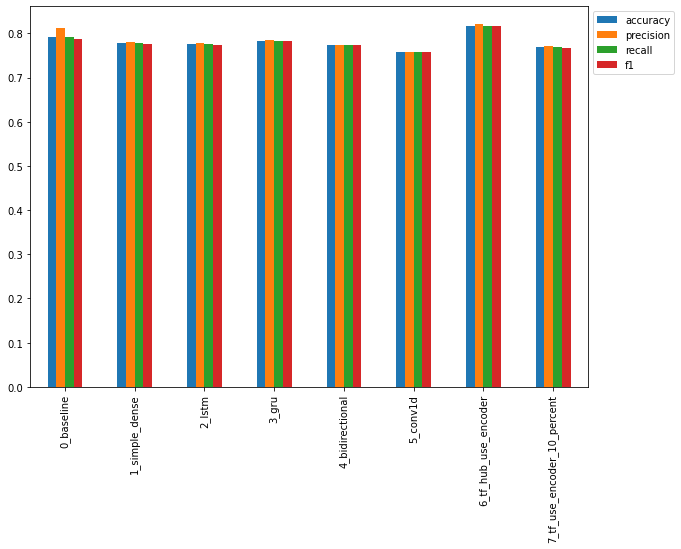

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

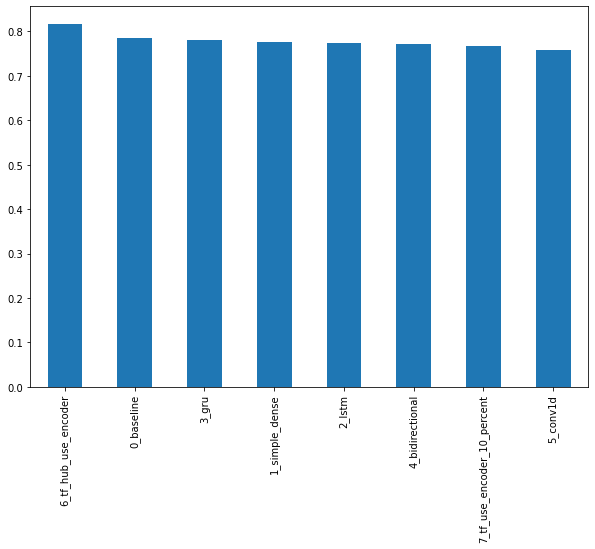

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7))

## Uploading our model training logs to TensorBoard.dev
We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name 'NLP Modelling Experiments ZTM TF Course Video' \
#   --description 'Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset' \
#   --one_shot  # exit the uploader once uploading is finished

Now I've ran the cell above, my modelling experiments are visible on TensorBoard.dev:
https://tensorboard.dev/experiment/a7Bzg78pQJq6ZAVJ1r4gSg/

> **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

In [ ]:
# See the previous TensorBoard Dev experiments you've run...
# !tensorboard dev list

In [ ]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id ZnGYxhwpRPysZsxUQqsD4Q

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
# model_6.save('model_6.h5')

In [ ]:
# Load model with custom Hub Layer (required HDF5 format)
# loaded_model_6 = tf.keras.models.load_model('model_6.h5',
#                                             custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
# loaded_model_6.evaluate(val_sentences, val_labels)

Now let's save to the `SavedModel` format... (see more on this here: https://www.tensorflow.org/tutorials/keras/save_and_load)

In [ ]:
# Save TF Hub Sentence Encoder model SavedModel format (default)
# model_6.save('model_6_SavedModel_format')

In [ ]:
# Load in a model from the SavedModel format
# loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [ ]:
# Evaluate model in SavedModel format
# loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

In [ ]:
# model_6_results

## Finding the most wrong examples

- If our best model still isn't perfect, what examples is it getting wrong?
- And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilisties closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-07-15 06:59:45--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 142.250.73.208, 142.250.73.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   230MB/s    in 4.0s    

2021-07-15 06:59:49 (228 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.

In [ ]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_pretrained_preds,
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
# Find the wrong predictions and sort by predcition probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong.head(10)  # flase positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
most_wrong.tail(10)  # these are false negatives

,text,target,pred,pred_prob
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067303
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055076
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
221,going to redo my nails and watch behind the sc...,1,0.0,0.054597
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049637
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target labels
- 0 = not disaster
- 1 = disaster

In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Text:\n{text}\n')
  print('----\n')

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [ ]:
# Check the false negatives (model predicted 1 when should've been 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Text:\n{text}\n')
  print('----\n')

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507579818367958
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963728412985802
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

## Making predictions on the test dataset

In [ ]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))  # our model expect list as input
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)}, Prob: {pred_prob}')
  print(f'Text:\n{test_sample}\n')
  print('-----\n')

Pred: 0, Prob: 0.11479883641004562
Text:
The only reason why player's now have an ego is cause MW3 had cod champs that's when eSports Blew up and now player's strictly look for ORGs

-----

Pred: 0, Prob: 0.11554187536239624
Text:
? Stretcher in 5 min // Speaker Deck http://t.co/gXgJqQu3hU #pctool

-----

Pred: 0, Prob: 0.23403656482696533
Text:
I so want to #win an ARC of WHEN WE COLLIDED Emery Lord's 2016 release! Open intl #TheStartofEmandYou #giveaway
 http://t.co/qcu4xO54wT

-----

Pred: 0, Prob: 0.07968068867921829
Text:
@TypeEd been a bit inundated w. Illustrative work  BUT would love to catch up! ??????

-----

Pred: 1, Prob: 0.9486056566238403
Text:
Severe Thunderstorm Warning until 10:30 PM local for Oklahoma County in OK. 60 Mph Wind Gusts And Half Dollar Size Hail. #okwx #myswc

-----

Pred: 1, Prob: 0.9769763350486755
Text:
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_

-----

Pr

## The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
def pred_timer(model, samples):
  '''
  Times how long a model takes to make predictions on samples.
  '''
  start_time = time.perf_counter()  # get start time
  model.predict(samples)  # make predictions
  end_time = time.perf_counter()  # get finish time
  total_time = end_time-start_time  # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.27089410899998256, 0.00035550408005247054)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.01829862099998536, 2.401393832019076e-05)

In [ ]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

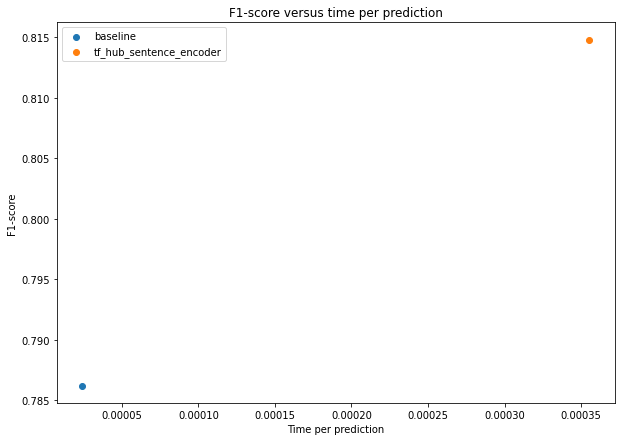

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentence_encoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score');